In [2]:
#!pip install exspy
#!pip install exspy --upgrade
#!pip install numba
#!pip install hyperspy --upgrade
!python3.10 -m ipykernel install --user

Installed kernelspec python3 in /Users/williamrigaut/Library/Jupyter/kernels/python3


C_Ka at 0.2774 keV : Intensity = 3729.00
Co_Ka at 6.9303 keV : Intensity = 12690.00
Dy_La at 6.4952 keV : Intensity = 6907.00
O_Ka at 0.5249 keV : Intensity = 11302.00
Pd_La at 2.8386 keV : Intensity = 7719.00
Si_Ka at 1.7397 keV : Intensity = 763409.00
[<BaseSignal, title: X-ray line intensity of DyCo-Pd_1-6: C_Ka at 0.28 keV, dimensions: (1|)>, <BaseSignal, title: X-ray line intensity of DyCo-Pd_1-6: Co_Ka at 6.93 keV, dimensions: (1|)>, <BaseSignal, title: X-ray line intensity of DyCo-Pd_1-6: Dy_La at 6.50 keV, dimensions: (1|)>, <BaseSignal, title: X-ray line intensity of DyCo-Pd_1-6: O_Ka at 0.52 keV, dimensions: (1|)>, <BaseSignal, title: X-ray line intensity of DyCo-Pd_1-6: Pd_La at 2.84 keV, dimensions: (1|)>, <BaseSignal, title: X-ray line intensity of DyCo-Pd_1-6: Si_Ka at 1.74 keV, dimensions: (1|)>]
---
C_Ka at 0.2774 keV : Intensity = 2808.26
Co_Ka at 6.9303 keV : Intensity = 12100.17
Co_La at 0.7757 keV : Intensity = 12524.52
Dy_La at 6.4952 keV : Intensity = 6759.57
Dy_M

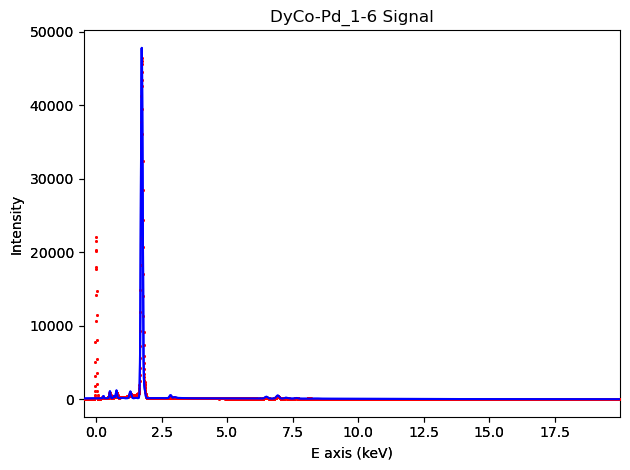

In [3]:
import exspy;
import hyperspy.api as hs;
import numpy as np;
#from hyperspy import quantification;

#reading spectrum.txt file
with open('./data/EDX/DyCo-Pd_1-6/Spectrum_(11,1).txt') as file:
    for line in file:
        if line.startswith("Primary energy"):
            beam_energy = float(line.split(': ')[1].strip());
        elif line.startswith("Tilt angle"):
            tilt_stage = float(line.split(': ')[1].strip());
        elif line.startswith("Azimut angle"):
            azimuth_angle = float(line.split(': ')[1].strip());
        elif line.startswith("Take off angle"):
            elevation_angle = float(line.split(': ')[1].strip());
        elif line.startswith("Mn FWHM"):
            energy_resolution_MnKa = float(line.split(': ')[1].strip());
        elif line.startswith("Calibration, abs."):
            offset = float(line.split(': ')[1].strip())/1000;
        elif line.startswith("Calibration, lin."):
            scale = float(line.split(': ')[1].strip())/1000;
            
        elif line.startswith("Energy Counts"):
            data_tab = [int(y) for y in file.read().split()[1::2]];
            break;

#add data inside a signal1D
s = hs.signals.Signal1D(data_tab);

#set EDX metadata parameters
s.set_signal_type('EDS_SEM');
s.metadata.General.title = 'DyCo-Pd_1-6';
s.set_microscope_parameters(beam_energy = beam_energy,
                            tilt_stage=tilt_stage,
                            azimuth_angle=azimuth_angle,
                            elevation_angle=elevation_angle,
                            energy_resolution_MnKa= energy_resolution_MnKa);
#set energy axes and scale
s.axes_manager[-1].name = 'E';
s.axes_manager['E'].units = 'keV';
s.axes_manager['E'].scale = scale;
s.axes_manager['E'].offset = offset;

#definie element to characterize
s.set_elements(['Si', 'Co', 'Dy','Pd', 'C', 'O']);
s.add_lines();

#display stuff
print(s.get_lines_intensity(plot_result=True));
print("---")
#background substraction and intensities calculations
bw = s.estimate_background_windows(line_width=[5.0, 1.0]);
m = s.create_model();
m.fix_background();

m.fit();
m.fit_background(start_energy=2.0);

intensities = m.get_lines_intensity(background_windows=bw, plot_result=True);
m.plot(navigator='slider', autoscale='x');

#print(hs.quantification);